In [2]:
import pandas as pd
import matplotlib.pyplot as plt
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.cross_validation import cross_val_score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train = pd.read_csv('train.csv', index_col='_id')

In [4]:
def category(df_input, NameCol):
    
    val_col = set(df_input[NameCol][df_input[NameCol].notnull()])
    j=0
    for i in val_col:
        #if i!="unknown":
        df_input[NameCol+'_'+i]=df_input[NameCol].map(lambda x: 1 if x == i else 0)
        j=j+1
    
    df_input= df_input.drop(NameCol, axis = 1)
    
    return df_input

In [5]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    
   # ранжируем, что можно
    df_output['education']=df_output['education'].map(lambda x: 0 if x == "illiterate"
                                                     else (1 if x == "basic.4y" 
                                                          else (2 if x == "basic.6y"
                                                               else (3 if (x == "basic.9y" or x == "unknown")
                                                                    else (4 if x == "professional.course"
                                                                         else (5 if x == "high.school"
                                                                              else 6))))))
    df_output=df_output.drop('education',1)

    df_output['default']=df_output['default'].map(lambda x: 1 if x == 'yes' else 0)
    df_output = df_output.drop('default',1)
    
    df_output['housing']=df_output['housing'].map(lambda x: 1 if x == 'yes' else 0)
    df_output = df_output.drop('housing',1)
    
    df_output['loan']=df_output['loan'].map(lambda x: 1 if x == 'yes' else 0)
    df_output = df_output.drop('loan',1)
    
    df_output=df_output.fillna(value = {'duration':0})
    df_output['duration']=df_output['duration'].map(lambda x: df_output['duration'].mean() if x == 0 else x)
    df_output = df_output.drop('duration',1)
    
    df_output['poutcome']=df_output['poutcome'].map(lambda x: 10 if x ==  "success" else (1 if x == "nonexistent" else 0))
    df_output = df_output.drop('poutcome',1)
    
    
    numC = pd.Series(dtype=int)
    for i in df_output.columns: 
        if str(df_output[i].dtype) == 'object':
               df_output= category(df_output,i)
        else:  # NaN в числовых колонках заполним 0
            numC[i]=0
    df_output=df_output.fillna(value=numC)
    
   
    return df_output

In [6]:
trr=train.pipe(preproc_data)

In [7]:
target = trr['target']
trr = trr.drop('target',axis=1)

In [8]:
from sklearn.cross_validation import train_test_split

X, X_test, y, y_test = train_test_split(trr, target)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([
    ('scaler', StandardScaler(with_std=False)),
    ('knn', KNeighborsClassifier(n_neighbors=30, weights='distance',))
])


In [10]:
knn.fit(X,y)
predict=knn.predict(X_test)
predict_p=knn.predict_proba(X_test)
roc = roc_auc_score(y_test, predict_p[:,1])
roc

0.75465178510107

Text(0,0.5,'ROC AUC')

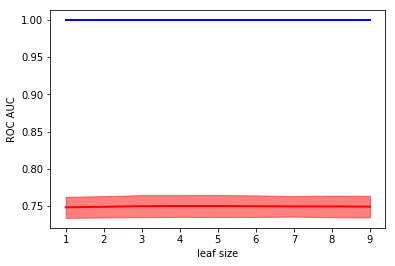

In [18]:
model = KNeighborsClassifier(n_neighbors=30, weights='distance')

cv = StratifiedKFold(n_splits=5, shuffle=True)

train_scores, valid_scores = validation_curve(model, X, y, 
                                              'p', range(1, 10),
                                              cv=cv, scoring='roc_auc')
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2)
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2)

plt.xlabel('leaf size')
plt.ylabel('ROC AUC')

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

dtc = Pipeline([
    ('scaler', StandardScaler()),
    ('dtc', DecisionTreeClassifier(criterion='gini',max_depth=5, min_samples_split=115, \
                                   min_samples_leaf=8,max_leaf_nodes=45, min_weight_fraction_leaf=0.0009, \
                                  max_features=0.4))
])

In [74]:

model = DecisionTreeClassifier(max_depth=5)

cv = StratifiedKFold(n_splits=5, shuffle=True)

train_scores, valid_scores = validation_curve(model, X, y, 
                                              'min_impurity_decrease', range(0, 0.19, 0.01),
                                              cv=cv, scoring='roc_auc')
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1, 20), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1, 20), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1, 20), train_score_mean, c='b', lw=2)
plt.plot(range(1, 20), valid_scores_mean, c='r', lw=2)

plt.xlabel('max_features')
plt.ylabel('ROC AUC')

TypeError: 'float' object cannot be interpreted as an integer

In [12]:
dtc.fit(X,y)
predict=dtc.predict_proba(X_test)
ras = roc_auc_score(y_test,predict[:,1])
ras

0.8057140598657757

In [13]:
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())])

In [14]:
lr.fit(X,y)
predict=lr.predict_proba(X_test)
ras = roc_auc_score(y_test,predict[:,1])
ras

0.8064022869197984

In [22]:
!pip3 install pymystem3

In [20]:
import pymorphy2